In [1]:
%matplotlib inline

import glob
from platform import python_version

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
# import torch

In [68]:
from sklearn.impute import SimpleImputer
df = pd.read_csv('per_person_data/out_AS14.23.csv')
df = df.dropna(thresh=2, subset=['activity', 'call', 'mood', 'screen'])
df = df.dropna(how='all', subset=['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
df = df.sort_values('time')
print(df)
df = df.fillna({'call':0,'sms':0, 'appCat.builtin':0, 'appCat.communication':0, 'appCat.unknown':0,
       'appCat.entertainment':0, 'appCat.other':0, 'appCat.social':0, 'appCat.finance':0, 'appCat.game':0, 'appCat.office':0, 'appCat.travel':0, 'appCat.utilities':0, 'appCat.weather':0,  'appCat.weather':0})
# df = df.drop(columns=['appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
df = df.drop(columns=['appCat.unknown'])
# df = df.fillna(df.median(numeric_only=True))
# print(df.shape)
# df.drop_duplicates(subset=['time'])
df = df.iloc[: , 1:]
df_no_time = df.select_dtypes(include=['int64','float64'])
print(df_no_time.shape)
# print(df_no_time)
# df_no_time.columns
data = df_no_time.to_numpy()
print(np.argwhere(data[np.isnan(data)]))

im = SimpleImputer(missing_values=np.nan, strategy="median")
result = im.fit_transform(data)
print(result)
# data = df_no_time.to_numpy()
# # print(data)
# h, w = data.shape
# # print(h, w)

# shape = (6,w)
# new_data = sliding_window_view(data, shape)

    Unnamed: 0        time  activity  appCat.builtin  appCat.communication  \
27          12  2014-03-22  0.371361       25.241688             24.304156   
28       16968  2014-03-23  0.217996       19.090643             34.981971   
29       16983  2014-03-24  0.355413       26.189233             18.445960   
30       17007  2014-03-25  0.274954       21.629851             30.290984   
31       17031  2014-03-26  0.405049        8.758588             35.726369   
32       17055  2014-03-27  0.356218       18.962623             54.889647   
33       17077  2014-03-28  0.405412       10.331565             29.506020   
34       17101  2014-03-29  0.397176       22.492611             23.053708   
35       17125  2014-03-30  0.418194       14.227364             15.994000   
36       17139  2014-03-31  0.383015       25.317161             38.086881   
37       17163  2014-04-01  0.511297       11.200867             32.766246   
38       17187  2014-04-02  0.469348       27.498537            

In [74]:
from sklearn.preprocessing import StandardScaler
from numpy.lib.stride_tricks import sliding_window_view

np.seterr(divide='ignore', invalid='ignore')

def data_generator(data):
    h, w = data.shape
    # print(h, w)

    shape = (6,w)
    new_data = sliding_window_view(data, shape)
    n, *_ = new_data.shape
    new_data = new_data.reshape((n,6,w))
    return new_data

def transform_data(arr):
    x_arr = arr[:,:-1]
    y_arr = arr[:,-1,-3]
    return x_arr, y_arr

#反标准化
def inverse_label(data, width):
    l, *_ = data.shape
    data_trans = np.zeros((l, width))
    data_trans[:,-3] = data.reshape((l))
    data_trans = scaler.inverse_transform(data_trans)
    return data_trans[:,-3]

Fill in nan value with per person dataset's median    

In [57]:
# Data Scaling 
# Fill in nan with per person dataset's median    
empty = []
all_data = np.array(empty)

files = sorted(glob.glob('per_person_data/*.csv'))
# files = sorted(glob.glob('test/*.csv'))
for f in files:
    df = pd.read_csv(f)
    df = df.dropna(thresh=2, subset=['activity', 'call', 'mood', 'screen'])
    df = df.dropna(how='all', subset=['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
    df = df.sort_values('time')
    # df = df.fillna({'call':0,'sms':0})
    # df = df.dropna(thresh=int(0.5*len(df)), axis=1)
    df = df.fillna({'call':0,'sms':0, 'appCat.builtin':0, 'appCat.communication':0, 'appCat.entertainment':0, 'appCat.other':0, 'appCat.social':0})
    df = df.drop(columns=['appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
    df = df.fillna(df.mean(numeric_only=True))
    # print(df.shape)
    # df.drop_duplicates(subset=['time'])
    df = df.iloc[: , 1:]
    df_no_time = df.select_dtypes(include=['int64','float64'])
    data = df_no_time.to_numpy()
    
    new_data = data_generator(data)
    
    if all_data.size == 0:
        all_data = new_data
    else:
        all_data = np.concatenate((all_data, new_data), axis=0)    

# scale data
scaler = StandardScaler()
nsamples, nx, ny = all_data.shape
trans_data = all_data.reshape((nsamples*nx, ny))
trans_data = scaler.fit_transform(trans_data).reshape((nsamples, nx, ny))

Fill in nan value with all dataset's median

In [85]:
# Data Scaling 
# Fill in nan with all dataset's median
from sklearn.impute import SimpleImputer
empty = []
all_data = np.array(empty)

files = sorted(glob.glob('per_person_data/*.csv'))
# files = sorted(glob.glob('test/*.csv'))
for f in files:
    df = pd.read_csv(f)
    df = df.dropna(thresh=2, subset=['activity', 'call', 'mood', 'screen'])
    df = df.dropna(how='all', subset=['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
    df = df.sort_values('time')
    # df = df.fillna({'call':0,'sms':0})
    # df = df.dropna(thresh=int(0.5*len(df)), axis=1)
    df = df.fillna({'call':0,'sms':0, 'appCat.builtin':0, 'appCat.communication':0, 'appCat.entertainment':0, 'appCat.other':0, 'appCat.social':0})
    df = df.drop(columns=['appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'])
    # df = df.fillna(df.mean(numeric_only=True))
    df = df.iloc[: , 1:]
    df_no_time = df.select_dtypes(include=['int64','float64'])
    data = df_no_time.to_numpy()
    
    new_data = data_generator(data)
    
    if all_data.size == 0:
        all_data = new_data
    else:
        all_data = np.concatenate((all_data, new_data), axis=0)    

# scale data
scaler = StandardScaler()
nsamples, nx, ny = all_data.shape
all_data = all_data.reshape((nsamples*nx, ny))
im = SimpleImputer(missing_values=np.nan, strategy="mean")
all_data = im.fit_transform(all_data)
trans_data = scaler.fit_transform(all_data).reshape((nsamples, nx, ny))
all_data = all_data.reshape((nsamples, nx, ny))

Fold: 0
Train set shape: (938, 5, 12)    Test set shape: (134, 5, 12)
Epoch 1/7
27/27 [==============================] - 6s 54ms/step - loss: 0.9904 - mse: 0.8734 - val_loss: 1.2492 - val_mse: 1.1689
Epoch 2/7
27/27 [==============================] - 0s 14ms/step - loss: 0.9617 - mse: 0.8824 - val_loss: 0.9717 - val_mse: 0.9016
Epoch 3/7
27/27 [==============================] - 0s 13ms/step - loss: 0.8762 - mse: 0.8094 - val_loss: 1.0014 - val_mse: 0.9438
Epoch 4/7
27/27 [==============================] - 0s 14ms/step - loss: 0.7834 - mse: 0.7237 - val_loss: 1.0577 - val_mse: 0.9970
Epoch 5/7
27/27 [==============================] - 0s 15ms/step - loss: 0.7929 - mse: 0.7393 - val_loss: 1.0510 - val_mse: 1.0020
Epoch 6/7
27/27 [==============================] - 0s 13ms/step - loss: 0.7473 - mse: 0.6949 - val_loss: 1.0583 - val_mse: 1.0085
Epoch 7/7
27/27 [==============================] - 0s 14ms/step - loss: 0.7336 - mse: 0.6851 - val_loss: 1.0059 - val_mse: 0.9601
Evaluate on test dat

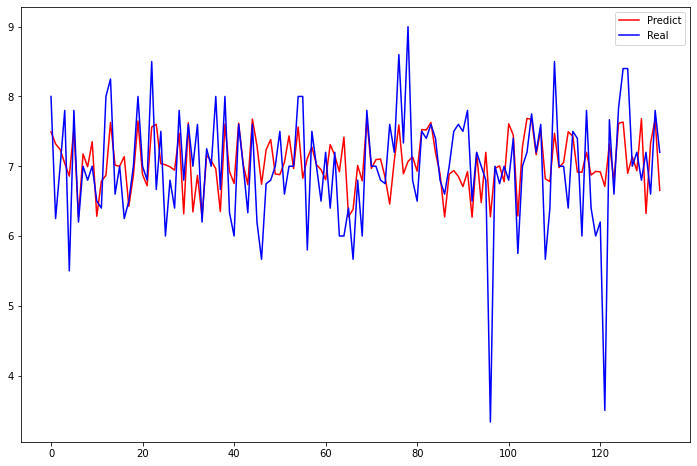

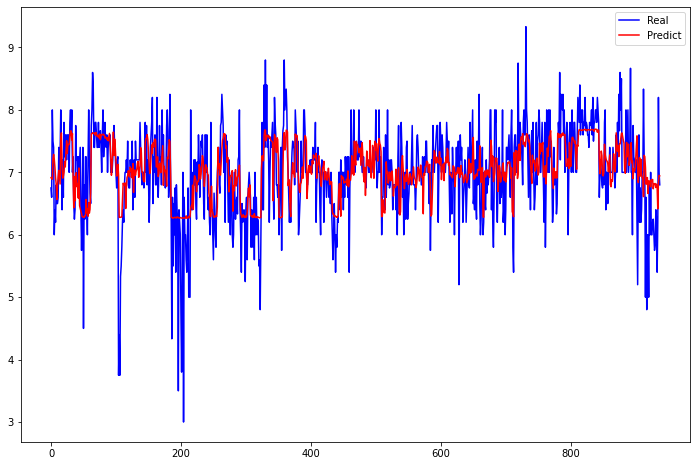

In [73]:
#RNN
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from keras_self_attention import SeqSelfAttention
from attention import Attention

# divide dataset
X, Y = transform_data(trans_data)

#Generate indices on the row-wise length of the whole 
#array
fold_indices = np.arange(X.shape[0])

#Shuffle the indices -- if you want, but not 
#neccessary
np.random.shuffle(fold_indices)

k = 8
#Split the indices into k-parts (returns a list of 
#numpy arrays)
cross_validatoin_score = []
test_all_x = np.array(empty)
test_all_y = np.array(empty)
eval_indices = np.array_split(fold_indices, k)
for idx, e in enumerate(eval_indices):
    #Define the evaluation set for the current fold
    test_set_x = X[e]
    test_set_y = Y[e]

    #exclude the upon parts indices from the 
    #whole array (similarly on the upon answers)
    
    mask_eval = np.ones(X.shape[0], bool)
    
    #Set indices of the eval set to false
    mask_eval[e] = False

    #Subset by the bool array:
    train_set_x = X[mask_eval].astype('float32')
    train_set_y = Y[mask_eval].astype('float32')
    print(f'Fold: {idx}')
    print(f'Train set shape: {train_set_x.shape}    Test set shape: {test_set_x.shape}')
    num_samples, time_steps, input_dim = train_set_x.shape

    model = Sequential()
    model.add(Input(shape=(time_steps, input_dim)))
    model.add(Bidirectional(LSTM(128,return_sequences=True)))
    model.add(Dropout(rate=0.3))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Bidirectional(LSTM(128,return_sequences=False)))
    model.add(Dropout(rate=0.7))
    # model.add(Attention(units=32))
    # model.add(Dense(4,activation="tanh",  kernel_regularizer=regularizers.l1(0.01)))
    # model.add(Dropout(rate=0.2))
    model.add(Dense(1,activation="tanh",  kernel_regularizer=regularizers.l1(0.01)))

    optimizer = optimizers.Adam(learning_rate=0.01, clipvalue=0.5)
    model.compile(optimizer=optimizer,loss="mean_squared_error", metrics=["mse"])
    model.fit(train_set_x,train_set_y,batch_size=32,epochs=7,validation_split=0.1,verbose=1)
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_set_x, test_set_y, batch_size=64)
    # print("test loss, test acc:", results)
    cross_validatoin_score.append(results)

    if test_all_x.size == 0:
        test_all_x = test_set_x
        test_all_y = test_set_y
    else:
        test_all_x = np.concatenate((test_all_x, test_set_x), axis=0)
        test_all_y = np.concatenate((test_all_y, test_set_y), axis=0)

    


_, _, w = train_set_x.shape
#预测测试集
# predict_trainY=model.predict(train_set_x)
predict_testY=model.predict(test_set_x)
#反标准化
# trainY=scaler.inverse_transform(predict_trainY)
testY_real = inverse_label(test_set_y[:,np.newaxis], w)
testY_predict = inverse_label(predict_testY, w)
# testY_real = Y_test
# testY_predict = predict_testY
print(model.summary())
print(np.mean(np.array(cross_validatoin_score),axis=0))

#看一看数据形状
print("Y:",testY_predict.reshape((-1)),testY_predict.shape)
print("Y_real:",testY_real,testY_real.shape)
plt.figure(figsize=(12,8))
plt.plot(testY_predict,"r",label="Predict")
plt.plot(testY_real,"b",label="Real")
plt.legend()
plt.show()


predict_trainY=model.predict(train_set_x)
#反标准化
trainY_real = inverse_label(train_set_y[:,np.newaxis], w)
trainY_predict = inverse_label(predict_trainY,w)

#看一看数据形状
# print("Y:",trainY_predict.reshape((-1)),trainY_predict.shape)
# print("Y_real:",trainY_real,trainY_real.shape)
plt.figure(figsize=(12,8))
plt.plot(trainY_real,"b",label="Real")
plt.plot(trainY_predict,"r",label="Predict")
plt.legend()
plt.show()

In [82]:
# ML LR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
# divide dataset
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
k = 8
lr=LinearRegression()
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(lr,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))

cross Validation scores: [-0.36065008 -0.4999547  -0.4601634  -0.42206152 -0.31774784 -0.30224604
 -0.4431784  -0.47340653]
Average Cross Validation score :0.40992606304549317


In [83]:
# ML Rigid
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV
# divide dataset
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

ridge=RidgeCV(alphas=np.arange(1,1001,100))
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(ridge,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))


cross Validation scores: [-0.32838622 -0.48701642 -0.46430072 -0.41855522 -0.31605878 -0.30243062
 -0.43275196 -0.45996222]
Average Cross Validation score :0.40118277038367145


In [49]:
# ML Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LassoCV
# divide dataset
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

lasso=LassoCV()
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(lasso,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))

cross Validation scores: [-0.32617646 -0.47652013 -0.46334056 -0.42138244 -0.32951973 -0.30335111
 -0.41410496 -0.46102945]
Average Cross Validation score :0.3994281061049812


In [72]:
# ML SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
# divide dataset
X, Y = transform_data(trans_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
clf = SVR(kernel='linear')
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(clf,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))

cross Validation scores: [-0.64512646 -0.99451673 -0.86588551 -0.74255745 -0.57630312 -0.54240643
 -0.8115621  -0.8995581 ]
Average Cross Validation score :0.7597394880684648


In [39]:
# ML KNN
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# divide dataset
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
neigh = KNeighborsRegressor(n_neighbors=2)
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(neigh,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))

cross Validation scores: [-0.56228855 -0.88534097 -0.77799675 -0.89041068 -0.72211849 -0.60733849
 -0.64037645 -0.72257391]
Average Cross Validation score :0.7260555353387392


In [40]:
# ML RandomForestReg
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(regr,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))


cross Validation scores: [-0.36229277 -0.48878181 -0.53932085 -0.45288439 -0.37063412 -0.31938478
 -0.37906009 -0.46010508]
Average Cross Validation score :0.42155798542799255


In [41]:
import xgboost as xgb
X, Y = transform_data(all_data)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
xgb_model = xgb.XGBRegressor(max_depth = 3,
                             learning_rate = 0.1,
                             n_estimators = 100,
                             objective = 'reg:squarederror',
                             n_jobs = -1)

kf=KFold(n_splits=k, shuffle=True, random_state=0)
score=cross_val_score(xgb_model,X,Y,cv=kf,scoring='neg_mean_squared_error')
print("cross Validation scores: {}".format(score))
print("Average Cross Validation score :{}".format(np.negative(score.mean())))


cross Validation scores: [-0.3313076  -0.50351054 -0.49549615 -0.45903115 -0.36421441 -0.31519577
 -0.39583635 -0.48408638]
Average Cross Validation score :0.4185847929951973


In [143]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12796032703250822253
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4859428864
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17627385420302940267
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [146]:


X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
num_samples, time_steps, input_dim = X_train.shape

model = Sequential()
model.add(Input(shape=(time_steps, input_dim)))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
# model.add(LSTM(16,return_sequences=False))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
# model.add(Attention(name='attention_weight'))
model.add(Dense(4,activation="tanh",  kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(rate=0.2))
model.add(Dense(1,activation="tanh",  kernel_regularizer=regularizers.l1(0.01)))

optimizer = optimizers.Adam(learning_rate=0.01, clipvalue=0.5)
model.compile(optimizer=optimizer,loss="mean_squared_error", metrics=["mse"])
model.fit(X_train,Y_train,batch_size=64,epochs=7,validation_split=0.1,verbose=1)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)
# print(f'Evaluate: {model.evaluate(X_test,Y_test, verbose=1)}')
model.summary()

Epoch 1/7
14/14 [==============================] - 4s 66ms/step - loss: 1.2709 - mse: 0.9954 - val_loss: 1.2529 - val_mse: 1.1014
Epoch 2/7
14/14 [==============================] - 0s 11ms/step - loss: 1.0844 - mse: 0.9914 - val_loss: 1.1498 - val_mse: 1.1026
Epoch 3/7
14/14 [==============================] - 0s 11ms/step - loss: 1.0260 - mse: 0.9850 - val_loss: 1.1339 - val_mse: 1.1042
Epoch 4/7
14/14 [==============================] - 0s 11ms/step - loss: 1.0076 - mse: 0.9841 - val_loss: 1.1220 - val_mse: 1.1035
Epoch 5/7
14/14 [==============================] - 0s 11ms/step - loss: 0.9990 - mse: 0.9836 - val_loss: 1.1163 - val_mse: 1.1041
Epoch 6/7
14/14 [==============================] - 0s 11ms/step - loss: 0.9946 - mse: 0.9836 - val_loss: 1.1135 - val_mse: 1.1041
Epoch 7/7
14/14 [==============================] - 0s 11ms/step - loss: 0.9920 - mse: 0.9835 - val_loss: 1.1121 - val_mse: 1.1050
Evaluate on test data
1/1 [==============================] - 0s 20ms/step - loss: 0.8271 -

Y: [6.61274545 6.84384563 6.89770911 6.88569513 6.84497614 6.19583858
 6.4101927  6.05271614 6.01152417 6.75359215 6.49160783 6.4610929
 6.8452054  6.65601756 6.72151282 6.51851872 6.39197532 6.31747518
 6.70189907 6.36501275 6.43093985 6.24047733 6.39421038 6.54017259
 6.34541469 6.48668693 6.76225766 6.83798104 6.4390309  6.4278031
 6.20346536 6.25235639 6.25911009 6.40272667 6.07427358 6.29750627
 6.44626111 6.46833295 6.5419035  6.16346067 6.13417561 6.61838873
 6.79693643 6.68593598 6.6116129  6.86329682 6.60024802 6.37889885
 6.17444381 6.05277672 5.90124206 6.85041645 6.66789126 6.64903773
 6.75559927 6.89918436 7.07340844 7.04628658 7.03882821 7.14147601
 7.0332508  6.90499503 7.03664447 7.01703157 6.7270712  6.2862776
 6.61689289 6.87976188 6.63711881 6.27704133 7.21874033 6.97816233
 6.76498362 6.15146715 7.19945095 6.97588852 6.86385143 6.95140791
 6.54476997 6.30022798 6.58838695 6.60615025 7.06865895 6.72955582
 6.21434589 6.0962567  5.97122234 6.86605686 7.02030129 6.8390

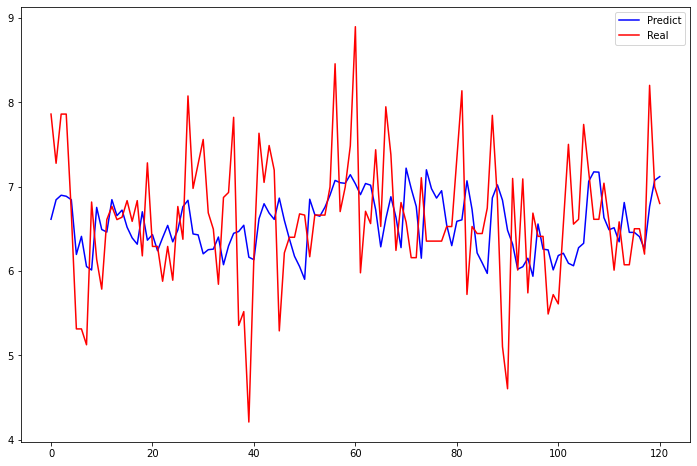

In [57]:
#反标准化
def inverse_label(data, width):
    l, _ = data.shape
    data_trans = np.zeros((l, width))
    data_trans[:,-3] = data.reshape((l))
    data_trans = scaler.inverse_transform(data_trans)
    return data_trans[:,-3]

h, _, w = X_train.shape
#预测测试集
predict_trainY=model.predict(X_train)
predict_testY=model.predict(X_test)
#反标准化
# trainY=scaler.inverse_transform(predict_trainY)
testY_real = inverse_label(Y_test[:,np.newaxis], w)
testY_predict = inverse_label(predict_testY, w)
# testY_real = Y_test
# testY_predict = predict_testY


#看一看数据形状
print("Y:",testY_predict.reshape((-1)),testY_predict.shape)
print("Y_real:",testY_real,testY_real.shape)
plt.figure(figsize=(12,8))
plt.plot(testY_predict,"b",label="Predict")
plt.plot(testY_real,"r",label="Real")
plt.legend()
plt.show()

Y: [-7.38032401e-01 -7.30555356e-01 -7.25347221e-01 -4.75297749e-01
  4.34011281e-01  5.65873682e-01 -1.27691627e-01 -3.52737725e-01
 -6.73373461e-01 -1.79499596e-01 -6.79012179e-01 -7.19876587e-01
 -4.86992151e-01 -4.28770036e-01 -4.18888927e-01 -4.71820652e-01
  2.84896135e-01  3.85179251e-01  1.15135312e-01  3.15459222e-02
 -1.82977572e-01 -1.92597792e-01 -3.82384688e-01 -5.43445051e-01
  3.48276287e-01  4.27155048e-01  3.90868694e-01  4.44348574e-01
  3.76045555e-01  6.03868544e-01  6.39254332e-01  4.56041217e-01
  5.21672845e-01  3.04816931e-01  4.09023345e-01 -1.74043011e-02
  1.18667029e-01 -2.59543508e-01 -5.25442421e-01 -5.63536942e-01
  5.09158432e-01  6.34659469e-01  6.23707712e-01  7.42245436e-01
  5.00310242e-01  4.95222002e-01  2.98525453e-01 -1.38441585e-02
  3.92121896e-02 -5.47466464e-02  6.62982091e-02 -1.00128464e-01
 -1.98274091e-01 -7.55433440e-01 -2.12401643e-01 -9.27510634e-02
  1.09047383e-01 -5.41207157e-02  8.36335216e-03 -6.22353889e-02
  6.42408967e-01  2.40

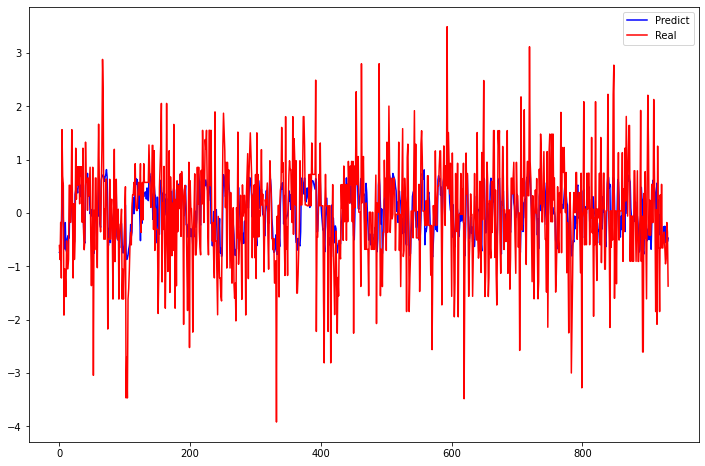

In [58]:
#看一看数据形状
# trainY_predict = inverse_label(predict_trainY, w)
# trainY_real = inverse_label(Y_train[:,np.newaxis], w)
trainY_predict = predict_trainY
trainY_real = Y_train

print("Y:",trainY_predict.reshape((-1)),trainY_predict.shape)
print("Y_real:",trainY_real,trainY_real.shape)
plt.figure(figsize=(12,8))
plt.plot(trainY_predict,"b",label="Predict")
plt.plot(trainY_real,"r",label="Real")
plt.legend()
plt.show()

In [124]:
# import tensorflow as tf
# from tensorflow.keras import layers,Input,optimizers
# from tensorflow.keras.layers import Bidirectional
# input_shape=Input(shape=(x_train.shape[1],x_train.shape[2]))
# lstm1=layers.LSTM(32,return_sequences=1)(input_shape)
# print("lstm1:",lstm1.shape)
# lstm2=layers.LSTM(64,return_sequences=0)(lstm1)
# print("lstm2:",lstm2.shape)
# dense1=layers.Dense(64,activation="relu")(lstm2)
# print("dense:",dense1.shape)
# dropout=layers.Dropout(rate=0.2)(dense1)
# print("dropout:",dropout.shape)
# ouput_shape=layers.Dense(1,activation="relu")(dropout)
# model=tf.keras.Model(input_shape,ouput_shape)
# model.compile(loss="mean_squared_error",optimizer="Adam",metrics=["mse"])#mse作为l损失函数，采用Adam作为寻优方式
# history=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_split=0.1,verbose=1)
# model.summary()

lstm1: (None, 5, 32)
lstm2: (None, 64)
dense: (None, 64)
dropout: (None, 64)
Epoch 1/10
2/2 [==============================] - 3s 550ms/step - loss: 0.9412 - mse: 0.9412 - val_loss: 0.9958 - val_mse: 0.9958
Epoch 2/10
2/2 [==============================] - 0s 34ms/step - loss: 0.9273 - mse: 0.9273 - val_loss: 0.9717 - val_mse: 0.9717
Epoch 3/10
2/2 [==============================] - 0s 30ms/step - loss: 0.9215 - mse: 0.9215 - val_loss: 0.9449 - val_mse: 0.9449
Epoch 4/10
2/2 [==============================] - 0s 35ms/step - loss: 0.9057 - mse: 0.9057 - val_loss: 0.9133 - val_mse: 0.9133
Epoch 5/10
2/2 [==============================] - 0s 34ms/step - loss: 0.9068 - mse: 0.9068 - val_loss: 0.8878 - val_mse: 0.8878
Epoch 6/10
2/2 [==============================] - 0s 34ms/step - loss: 0.9019 - mse: 0.9019 - val_loss: 0.8706 - val_mse: 0.8706
Epoch 7/10
2/2 [==============================] - 0s 30ms/step - loss: 0.8812 - mse: 0.8812 - val_loss: 0.8609 - val_mse: 0.8609
Epoch 8/10
2/2 [===

In [15]:
import torch
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

print(is_cuda)
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True
